In [1]:
import pandas as pd
import numpy as np
import re
import string
import gensim
from gensim import corpora
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

2023-04-14 10:52:49.933574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 10:52:50.752866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print('The length of the dataset is: ', len(data))

The length of the dataset is:  568454


In [4]:
import pyLDAvis
import pyLDAvis.gensim

In [5]:
print('The number of unique products are: ', len(data.groupby('ProductId')))
print('The number of unique users are:', len(data.groupby('UserId')))

The number of unique products are:  74258
The number of unique users are: 256059


In [6]:
#@ Cleaning the text present in the dataset
def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = ' '.join([w for w in textArr if (not w.isdigit() and (not w.isdigit() and len(w)>3))])
    return text2.lower()

In [7]:
import nltk
# nltk.download('stopwords')

In [8]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [9]:
#@ Let's drop those null values
data.dropna(axis=0, how='any', inplace=True)

In [10]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [12]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568411.000000,568411.000000,568411.000000,568411.000000,5.684110e+05
mean,284227.440964,1.743874,2.227876,4.183309,1.296261e+09
std,164099.020907,7.636781,8.288752,1.310368,4.803792e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142114.500000,0.000000,0.000000,4.000000,1.271290e+09
50%,284224.000000,0.000000,1.000000,5.000000,1.311120e+09
75%,426341.500000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09


In [13]:
#@ Let's clean the text column of the dataset
data['Text'] = data['Text'].apply(clean_text)
data['Num_words_text'] = data['Text'].apply(lambda x: len(str(x).split()))           # get the total number of text in the words

In [14]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Num_words_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,have bought several vitality canned food produ...,30
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,20
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection that been around centuries lig...,52
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe h...,22
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price there wide assortment ...,17


In [15]:
#@ Print the unique value present in the score column
print(data['Score'].value_counts())

5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64


In [16]:
#@ Len of data after removing the null values
print(len(data))

568411


In [17]:
#@ The maximum review data sentence length
print(data['Num_words_text'].max())

2234


In [18]:
mask = (data['Num_words_text'] < 100) & (data['Num_words_text'] >= 20)
data_short_reviews = data[mask]

data_sampled = data_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop=True)
print('The number of short reviews are:', len(data_short_reviews))

The number of short reviews are: 373281


**Applying Pre-Processing**

In [19]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

#@ Let's remove stopwords from the text
data_sampled['Text'] = data_sampled['Text'].apply(remove_stopwords)

In [20]:
import spacy
spacy.load("en_core_web_md")

In [21]:
#@ Applying lemmatization in the text
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUNS', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return output

In [38]:
text_list = data_sampled['Text'].tolist()
print(text_list[1])

ordered kettle chips following flavvorsbr salt fresh ground pepperbr tuscan cheesebr cheddar hersbr tasted variety pack suggest order ordering large sizebr wish could return unopened bags


In [23]:
tokenized_review = lemmatization(text_list)

In [36]:
tokenized_review[1]

['fresh', 'tuscan', 'large', 'unopened']

**Create vocabulary and document term matrix**

In [25]:
dictionary = corpora.Dictionary(tokenized_review)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_review]

In [26]:
#@ Creating the object for LDAmodel using gensim library
LDA = gensim.models.ldamodel.LdaModel

#@ Building LDA Model
lda_model = LDA(corpus=doc_term_matrix,
               id2word=dictionary,
               num_topics=10,
               random_state=100,
               chunksize=1000,
               passes=50,
               iterations=100)

In [27]:
lda_model.print_topics()

[(0,
  '0.104*"good" + 0.094*"nice" + 0.091*"little" + 0.079*"well" + 0.054*"great" + 0.039*"worth" + 0.038*"easy" + 0.037*"tasty" + 0.029*"hard" + 0.026*"crunchy"'),
 (1,
  '0.133*"small" + 0.079*"large" + 0.065*"last" + 0.052*"extra" + 0.042*"bold" + 0.032*"great" + 0.028*"little" + 0.024*"able" + 0.022*"light" + 0.022*"original"'),
 (2,
  '0.114*"fresh" + 0.084*"green" + 0.080*"good" + 0.078*"cheap" + 0.043*"great" + 0.037*"picky" + 0.027*"local" + 0.026*"well" + 0.026*"blue" + 0.020*"brown"'),
 (3,
  '0.154*"strong" + 0.064*"enough" + 0.047*"right" + 0.045*"quick" + 0.041*"open" + 0.036*"salty" + 0.034*"great" + 0.033*"special" + 0.025*"much" + 0.025*"instant"'),
 (4,
  '0.130*"free" + 0.079*"excellent" + 0.079*"good" + 0.057*"great" + 0.053*"smooth" + 0.031*"soft" + 0.029*"fantastic" + 0.025*"artificial" + 0.021*"first" + 0.021*"true"'),
 (5,
  '0.119*"healthy" + 0.092*"good" + 0.077*"organic" + 0.071*"whole" + 0.056*"great" + 0.029*"white" + 0.027*"little" + 0.024*"high" + 0.017*

In [28]:
#@ Visualizing the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, 
                              doc_term_matrix, 
                              dictionary)
vis

/home/saugat/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.111562 -0.018864       1        1  13.451407
8     -0.071124 -0.073647       2        1  11.383430
9     -0.214247  0.156999       3        1  10.604562
5     -0.123370  0.071891       4        1  10.572365
1      0.209893  0.086509       5        1  10.253679
4     -0.163746 -0.087374       6        1   9.221971
6      0.262116 -0.181385       7        1   9.077848
7      0.143945 -0.044652       8        1   8.963073
2     -0.077156 -0.195682       9        1   8.291975
3      0.145251  0.286205      10        1   8.179689, topic_info=       Term          Freq         Total Category  logprob  loglift
57     good  42548.000000  42548.000000  Default  30.0000  30.0000
165  strong   7756.000000   7756.000000  Default  29.0000  29.0000
130   small   8397.000000   8397.000000  Default  28.0000  28.0000
4      free   7396.000000   7396.000000  Default  27.0000  27.0000
61    sweet   8093.000000   8093.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
203   right   2381.972828   3325.205426  Topic10  -3.0496   2.1699
21     much   1273.874680   7061.723370  Topic10  -3.6754   0.7909
58    great   1724.038812  30796.350307  Topic10  -3.3728  -0.3792
118  little   1063.535690  14201.157042  Topic10  -3.8559  -0.0882
3     first    655.342950   5384.817412  Topic10  -4.3401   0.3973

[447 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
172       2  0.151951      able
172       5  0.463043      able
172       7  0.266383      able
172      10  0.118184      able
252       6  0.998553  absolute
...     ...       ...       ...
102       1  0.840507     worth
102       9  0.159371     worth
25        7  0.997909    yellow
536       8  0.997493     young
342       2  0.999602     yummy

[459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 10, 6, 2, 5, 7, 8, 3, 4])

In [29]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix, total_docs=10000))

#@ Computing the coherence score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model,
                                    texts=tokenized_review,
                                    dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Perplexity:  -8.067837600646321

Coherence Score: 0.2975853380582823


**To check if the model is good or not**

- Higher the `Coherence` the model is better
- Measure of how good the model is. lower the `Perplexitya` better.

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    '''
    Compute c_v coherence for various number of topics
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics, 
                                                id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [31]:
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                       corpus=doc_term_matrix,
                                                       texts=tokenized_review,
                                                       start=2,
                                                       limit=50,
                                                       step=1)

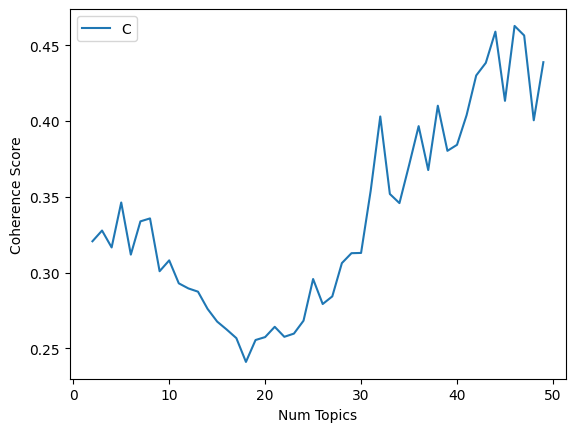

In [32]:
#@ Plotting the graph
limit = 50; start = 2; step = 1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Values"), loc='best')
plt.show()

In [33]:
#@ Printing the coherence score
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, "has Coherence Value of", round(cv, 4))

Num Topics =  2 has Coherence Value of 0.3207
Num Topics =  3 has Coherence Value of 0.3278
Num Topics =  4 has Coherence Value of 0.3166
Num Topics =  5 has Coherence Value of 0.3463
Num Topics =  6 has Coherence Value of 0.3119
Num Topics =  7 has Coherence Value of 0.3338
Num Topics =  8 has Coherence Value of 0.3358
Num Topics =  9 has Coherence Value of 0.3009
Num Topics =  10 has Coherence Value of 0.3081
Num Topics =  11 has Coherence Value of 0.2929
Num Topics =  12 has Coherence Value of 0.2896
Num Topics =  13 has Coherence Value of 0.2874
Num Topics =  14 has Coherence Value of 0.2761
Num Topics =  15 has Coherence Value of 0.2677
Num Topics =  16 has Coherence Value of 0.2624
Num Topics =  17 has Coherence Value of 0.2568
Num Topics =  18 has Coherence Value of 0.2411
Num Topics =  19 has Coherence Value of 0.2555
Num Topics =  20 has Coherence Value of 0.2574
Num Topics =  21 has Coherence Value of 0.2642
Num Topics =  22 has Coherence Value of 0.2576
Num Topics =  23 has 

In [34]:
#@ Selecting the model and print the topcis
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.080*"regular" + 0.051*"good" + 0.050*"able" + 0.039*"great" + 0.033*"white" + 0.029*"clean" + 0.026*"fantastic" + 0.024*"special" + 0.024*"single" + 0.021*"thick"'),
 (1,
  '0.094*"whole" + 0.057*"black" + 0.049*"available" + 0.042*"crunchy" + 0.032*"awesome" + 0.031*"salty" + 0.027*"little" + 0.027*"delicious" + 0.025*"plain" + 0.023*"nuts"'),
 (2,
  '0.103*"free" + 0.070*"strong" + 0.049*"good" + 0.045*"dark" + 0.039*"favorite" + 0.027*"mild" + 0.024*"happy" + 0.022*"french" + 0.020*"bitter" + 0.017*"weak"'),
 (3,
  '0.085*"good" + 0.065*"fresh" + 0.050*"great" + 0.041*"wonderful" + 0.039*"rich" + 0.036*"full" + 0.032*"amazing" + 0.031*"bold" + 0.027*"much" + 0.026*"easy"'),
 (4,
  '0.111*"nice" + 0.068*"good" + 0.052*"real" + 0.046*"great" + 0.040*"smooth" + 0.035*"little" + 0.030*"hard" + 0.027*"soft" + 0.019*"glad" + 0.017*"well"'),
 (5,
  '0.142*"great" + 0.083*"healthy" + 0.054*"first" + 0.049*"good" + 0.034*"little" + 0.030*"large" + 0.030*"right" + 0.029*"small" + 0.

In [35]:
#@ Visualzing the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optmial_model, 
                             doc_term_matrix,
                             dictionary)
vis

NameError: name 'optmial_model' is not defined

**The End**